In [24]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
import pickle
file = open("data_risk2_dummy","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [26]:
X_train.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
y_train.value_counts()

0    109536
1      4293
Name: cancer, dtype: int64

In [28]:
X_test.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [29]:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
#define pipeline
under = EditedNearestNeighbours(n_jobs=-1)
over = SMOTE(random_state=0, n_jobs=-1)
steps=[('u', under), ('o',over)]
pipeline = Pipeline(steps=steps)
X_rs, y_rs = pipeline.fit_resample(X_train, y_train)

In [30]:
from collections import Counter

Counter(y_rs)

Counter({0: 96418, 1: 96418})

In [31]:
X_train=X_rs
y_train=y_rs

# Model Building on Cancer Data

## <span style="color:blue">Model 3 - Weighted XGBoost</span>

### Default Hyperparameters

Let's first fit a random forest model with default hyperparameters.

In [32]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    # Let's see the sensitivity of our model
    print("Sensitivity:",TP / float(TP+FN))

    # Let us calculate specificity
    print("Specificity:",TN / float(TN+FP))

    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

In [33]:
# Importing random forest classifier from sklearn library
from xgboost import XGBClassifier

In [34]:
xgb = XGBClassifier(random_state = 100)

# fit
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train_def = xgb.predict(X_train) # For train data
y_pred_test_def = xgb.predict(X_test) # For test data

#### Evaluating model on balanced train data with default parameters

Confusion Matrix ->
[[92399  4019]
 [ 9249 87169]]
Accuracy: 0.9311954199423345
Sensitivity: 0.9040739281047108
Specificity: 0.9583169117799581
Precision 0.9559262183620651
MCC  0.8636623532904623
F1  0.9292773152244598
F2  0.9139894308602105
F3  0.9090046404922048
ROC-AUC : 0.98


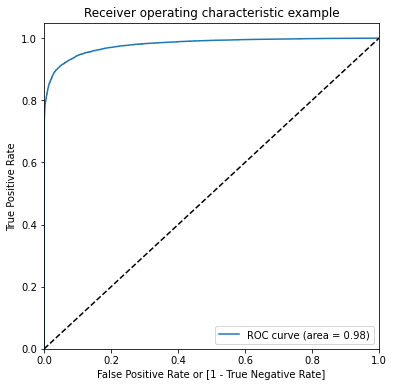

In [36]:
# For train
model_stats(X_train, y_train, y_pred_train_def, xgb)

#### Evaluating model on imbalanced test data with default parameters

Confusion Matrix ->
[[52099  5831]
 [  933   638]]
Accuracy: 0.886321238298516
Sensitivity: 0.4061107574793125
Specificity: 0.8993440359054031
Precision 0.09862420776008657
MCC  0.1573255370474629
F1  0.15870646766169155
F2  0.25013722261428684
F3  0.3095885093167702
ROC-AUC : 0.74


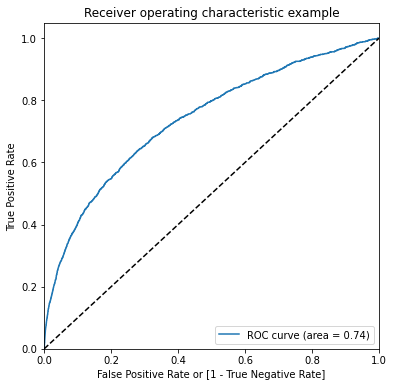

In [37]:
# For test
model_stats(X_test, y_test, y_pred_test_def, xgb)